### Correlating the proportion of a genes expression which is UTRon transcripts with the expression level of a gene. Results with: Novel UTRons, All UTRons, Random transcripts.

In [2]:
import sqlite3
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
import math
import random

# ATTACH UTRONS DATABASE
cnx = sqlite3.connect('/shared/sudlab1/General/projects/utrons_project/BladderCancerUtrons/431BladderUtrons.db')
cnx.execute("ATTACH '/shared/sudlab1/General/annotations/hg38_noalt_ensembl85/csvdb' as annotations")

sampleCount = 434

In [3]:
"""
GETTING PROPORTIONS
"""

"""
Function:
1 - get TPMs of the Tx Ids passed to the function
2 - get proportions of the tpms found in (1)

"""

#################################################  
# 1 - Get UTRon Tpms
#################################################  

# Get tpms for UTRons
def getTpms(sample, runNum, index, Dataframe):
    
    # Load file into dataframe
    sampleFile = '/shared/sudlab1/General/projects/utrons_project/BladderCancerUtrons/Quantifications/%s_agg-agg-agg.sf' % sample
    sampleDf = pd.read_csv(sampleFile, sep='\t') 
    
    # Copy only Tx ids and TPM values from dataframe
    sampleDf = sampleDf[[0,3]].copy() 
    
    # Merge with Utrons DF (get only utron tpms)
    sampleDf = pd.merge(Dataframe, sampleDf, right_on="Name", left_on="Name")
    
    # Make columns named with the sample number
    indexname = "TPM_%d" % index
    sampleDf[indexname] = sampleDf["TPM"]

    # If passed with runNum == 1, return tpms AND tx IDs, else return just the tpms
    if runNum ==1:
        return sampleDf[["Name","match_id", indexname]]
    if runNum ==2:
        return sampleDf[[indexname]]
    
        
         
        
#################################################        
# 2-  Get TPM totals for each gene in each sample
#################################################  

# Open each sample individually and get transcript tpms then groupby match_tx_id to get transcript_totals
def getGeneTotals(sampleNum, runNum, Dataframe):
    
    # Make vars with sample names and indexes
    sample="ZF-WT-%d" % sampleNum
    tpmIndex = "TPM_%d" % sampleNum
    propIndex = "PROP_%d" % sampleNum
    
    # Load file into dataframe
    sampleFile = '/shared/sudlab1/General/projects/utrons_project/BladderCancerUtrons/Quantifications/%s_agg-agg-agg.sf' % sample
    sampleDf = pd.read_csv(sampleFile, sep='\t') 
    
    # Copy only Tx ids and TPM values from dataframe, Merge with transcripts DF and group by ID to get gene sums
    sampleDf = sampleDf[["Name","TPM"]]
    sampleDf = pd.merge(transcriptIds, sampleDf, right_on="Name", left_on="Name") 
    sampleDf = sampleDf.groupby("match_id").sum()
    
    
    # Make a copy of the utrons dataframe tpms for the sample and merge utrons and sample dataframes
    utronTpms = Dataframe[["Name","match_id",tpmIndex]].copy()  
    utronTpms = pd.merge(utronTpms, sampleDf, right_index=True, left_on="match_id") 
    
    # get proportion for each transcript
    utronTpms[propIndex] = utronTpms[tpmIndex] / utronTpms["TPM"] 
    
    
    # Return dataframe
    if runNum == 1:
        return utronTpms[["Name", "match_id", propIndex]]
    if runNum ==2:
        return utronTpms[[propIndex]]

In [4]:
"""
SQL QUERIES TO GET TRANSCRIPT IDS TO BE USED LATER
"""

#########################################################
# Dataframe of all transcript IDs 
query_text1 = '''
    SELECT tc.match_gene_id AS match_id, tc.transcript_id AS Name
    FROM transcript_class AS tc
    WHERE tc.track="agg-agg-agg"
    ORDER BY match_transcript_id
    '''
transcriptIds = pd.read_sql_query(query_text1, cnx)



#########################################################
# Dataframe of novel UTRons IDs and matched transcript IDs
query_text1 = '''
    SELECT uid.transcript_id AS Name, tc.match_gene_id AS match_id
    FROM novel_utrons_ids AS uid
    INNER JOIN transcript_class AS tc
    ON tc.transcript_id = uid.transcript_id
    INNER JOIN annotations.transcript_info AS ti
    ON ti.transcript_id = tc.match_transcript_id
    WHERE uid.track='agg-agg-agg'
    GROUP BY uid.transcript_id
    '''
novelUtronsDf = pd.read_sql_query(query_text1, cnx)


#########################################################
# Dataframe of all UTRon IDs and matched transcript IDs
query_text1 = '''
    SELECT uid.transcript_id AS Name, tc.match_gene_id AS match_id
    FROM all_utrons_ids AS uid
    INNER JOIN transcript_class AS tc
    ON tc.transcript_id = uid.transcript_id
    INNER JOIN annotations.transcript_info AS ti
    ON ti.transcript_id = tc.match_transcript_id
    WHERE uid.track='agg-agg-agg'
    GROUP BY uid.transcript_id
    '''
allUtronsDf = pd.read_sql_query(query_text1, cnx)


In [5]:
"""
GETTING NOVEL UTRON TPMS AND PROPORTIONS USING THE ABOVE FUNCTIONS
"""


# Loop through samples and get tpms
novelUtronTpms = getTpms("ZF-WT-1", 1, 1, novelUtronsDf)
for num in range(2,sampleCount,1):
    if num != 252 and num != 347:
        sample = "ZF-WT-%d" % num
        sampleTpms = getTpms(sample, 2, num, novelUtronsDf)
        novelUtronTpms = pd.concat([novelUtronTpms, sampleTpms], axis=1)

        

# Loop through samples and get proportions  
novelUtronProportions = getGeneTotals(1, 1, novelUtronTpms)
for num in range(2,sampleCount,1):
    if num != 252 and num != 347:
        sampleProportions = getGeneTotals(num, 2, novelUtronTpms)
        novelUtronProportions = pd.concat([novelUtronProportions, sampleProportions], axis=1)


In [6]:
"""
GETTING ALL UTRON TPMS AND PROPORTIONS USING THE ABOVE FUNCTIONS
"""


# Loop through samples and get tpms
allUtronTpms = getTpms("ZF-WT-1", 1, 1, allUtronsDf)
for num in range(2,sampleCount,1):
    if num != 252 and num != 347:
        sample = "ZF-WT-%d" % num
        sampleTpms = getTpms(sample, 2, num, allUtronsDf)
        allUtronTpms = pd.concat([allUtronTpms, sampleTpms], axis=1)

        

# Loop through samples and get proportions  
allUtronProportions = getGeneTotals(1, 1, allUtronTpms)
for num in range(2,sampleCount,1):
    if num != 252 and num != 347:
        sampleProportions = getGeneTotals(num, 2, allUtronTpms)
        allUtronProportions = pd.concat([allUtronProportions, sampleProportions], axis=1)

In [7]:
"""
PICK A SET OF RANDOM TXS AND GET PROPORTIONS FOR THEM
"""

# Remove null values (cant find proportions for these genes)
transcriptIds = transcriptIds[transcriptIds["match_id"].notnull()] 


# pick a set of random numbers and add the corresponding genes to a db - randomtxs
indexvals = transcriptIds.index.tolist()
numTxs = 33673
randlist = []
picked = []


# Pick random set of numbers and add to list
while len(randlist) < numTxs:
    randomnum = random.randint(0,len(indexvals)-1)
    if randomnum not in randlist:
        randlist.append(randomnum)

# Pick the numbers generated from above
for num in randlist:
    picked.append(indexvals[num])

    
# Select transcripts corresponding to random numbers
randomTxs = transcriptIds.filter(picked, axis=0)


# Loop through samples and get tpms
randomTpms = getTpms("ZF-WT-1", 1, 1, randomTxs)
for num in range(2,sampleCount,1):
    if num != 252 and num != 347:
        sample = "ZF-WT-%d" % num
        sampleTpms = getTpms(sample, 2, num, randomTxs)
        randomTpms = pd.concat([randomTpms, sampleTpms], axis=1)

        

# Loop through samples and get proportions  
randomProportions = getGeneTotals(1, 1, randomTpms)
for num in range(2,sampleCount,1):
    if num != 252 and num != 347:
        sampleProportions = getGeneTotals(num, 2, randomTpms)
        randomProportions = pd.concat([randomProportions, sampleProportions], axis=1)

#### Have TPMs and proportions for each gene, now need to find the correlations
- Using scipy pearsonr

In [81]:
"""
FUNCTION TO GET CORRELATIONS
- Takes 2 dataframes - proportions and tpms
- Return pearson correlation as a list
"""

# Set Filter (needs x tpm in atleast x samples to meet filter)
tpmThreshold = 5
sampleThreshold1 = 10
sampleThreshold2 = 100

def getCorrelations(proportionDf, tpmDf):
    a = proportionDf.sort("Name")
    b = tpmDf.sort("Name")
    
    numTranscripts = len(a)
    transcriptRange = range(0, numTranscripts-1, 1)
    indexVals = a.index
    
    Correlations = []
    #for num in transcriptRange:
    for num in indexVals:
        proportions = a.ix[num,2:].tolist()
        tpms = b.ix[num,2:].tolist()
        
        stackedValues = np.column_stack([tpms, proportions])
        stackedValues = stackedValues[stackedValues[:,0] > tpmThreshold]
        
        if len(stackedValues) > sampleThreshold1 and len(stackedValues) < sampleThreshold2:
            correlation = pearsonr(stackedValues[:,1], stackedValues[:,0])
            Correlations.append(correlation[0])
            
    return Correlations

In [85]:
novelUtronCorrelations = getCorrelations(novelUtronProportions, novelUtronTpms)
allUtronCorrelations = getCorrelations(allUtronProportions, allUtronTpms)
RandomCorrelations = getCorrelations(randomProportions, randomTpms)

/home/mba13ns/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/mba13ns/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Populating the interactive namespace from numpy and matplotlib


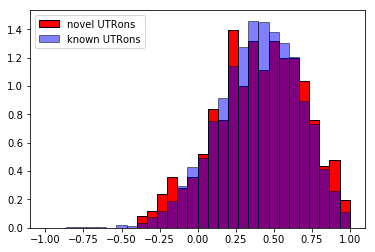

In [89]:
%pylab inline
pylab.hist(novelUtronCorrelations, bins=30, range=(-1,1), edgecolor="black", normed=True, label="novel UTRons", color="red")
pylab.hist(allUtronCorrelations, bins=30, range=(-1,1), edgecolor="black", normed=True,  label="known UTRons", color="blue", alpha=0.5,)
pylab.legend()
pylab.savefig("./images/10_FINALnovelVsKnown", dpi=300)

Populating the interactive namespace from numpy and matplotlib


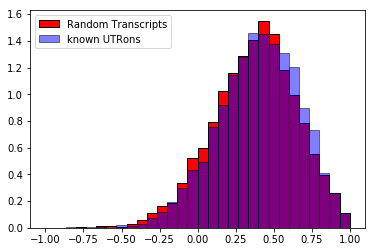

In [90]:
%pylab inline
pylab.hist(RandomCorrelations, bins=30, range=(-1,1), edgecolor="black", normed=True, label="Random Transcripts", color="red")
pylab.hist(allUtronCorrelations, bins=30, range=(-1,1), edgecolor="black", normed=True,  label="known UTRons", color="blue", alpha=0.5,)
pylab.legend()
pylab.savefig("./images/10_FINALknownVsRand", dpi=300)

Populating the interactive namespace from numpy and matplotlib


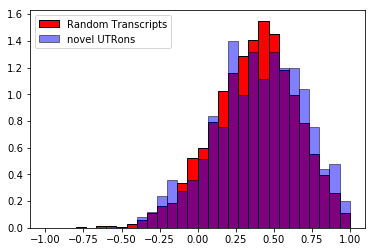

In [91]:
%pylab inline
pylab.hist(RandomCorrelations, bins=30, range=(-1,1), edgecolor="black", normed=True, label="Random Transcripts", color="red")
pylab.hist(novelUtronCorrelations, bins=30, range=(-1,1), edgecolor="black", normed=True,  label="novel UTRons", color="blue", alpha=0.5,)
pylab.legend()
pylab.savefig("./images/10_FINALnovelVsRand", dpi=300)

/home/mba13ns/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/mba13ns/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


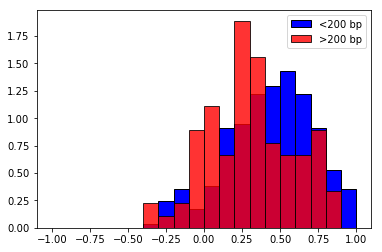

In [186]:
"""
Plotting novel UTRons correlations based on UTRon length
"""
Length = 200
lengthsFile = "/shared/sudlab1/General/projects/utrons_project/misc_files/SpliceSite/novelLengths.txt"
lengthsInfo = pd.read_csv(lengthsFile, "\t")
shortIds = lengthsInfo[lengthsInfo["Length"]<=Length]["transcript_id"]

shortUtronTpms = novelUtronTpms[novelUtronTpms["Name"].isin(shortIds)]
shortUtronProportions = novelUtronProportions[novelUtronProportions["Name"].isin(shortIds)]

longUtronTpms = novelUtronTpms[~novelUtronTpms["Name"].isin(shortIds)]
longUtronProportions = novelUtronProportions[~novelUtronProportions["Name"].isin(shortIds)]

shortUtronCorrelations = getCorrelations(shortUtronProportions, shortUtronTpms)
longUtronCorrelations = getCorrelations(longUtronProportions, longUtronTpms)


pylab.hist(shortUtronCorrelations, bins=20, range=(-1,1), edgecolor="black", normed=True, color="blue", label="<200 bp")
pylab.hist(longUtronCorrelations, bins=20, range=(-1,1), edgecolor="black", normed=True, color="red", alpha=0.8,label=">200 bp")
pylab.legend()
pylab.savefig("10_FINALlengthSplit", dpi=300)



In [41]:
"""
Plotting correlation of novel Utrons based on splice site type
"""

# File of novel utrons with non-canonical splice sites
badsplicefile = "/shared/sudlab1/General/projects/utrons_project/misc_files/SpliceSite/novelUtrons_unknown_100000bp.txt"
badspliceUtrons = pd.read_csv(badsplicefile, header=None, sep="\t", index_col=0)[1].tolist()


"""
Function returns the splice site status (1) = known, (0) = unknown
"""    
def spliceStatus(row):
    tx = row["Name"]
    if tx in badspliceUtrons:
        return 0
    else:
        return 1
    
    
novelTpms = novelUtronTpms
novelProps = novelUtronProportions
novelTpms["Splice"] = novelTpms.apply(spliceStatus, axis=1)
novelProps["Splice"] = novelProps.apply(spliceStatus, axis=1)


knownSpliceTpms = novelTpms[novelTpms["Splice"]==1]
unknownSpliceTpms = novelTpms[novelTpms["Splice"]==0]
knownSpliceProps = novelProps[novelProps["Splice"]==1]
unknownSpliceProps = novelProps[novelProps["Splice"]==0]

/home/mba13ns/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/mba13ns/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


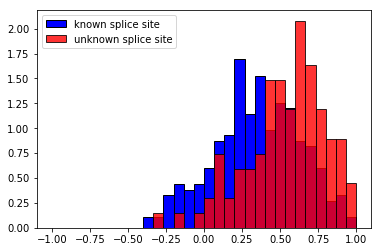

In [93]:
knownSpliceCorrelations = getCorrelations(knownSpliceProps, knownSpliceTpms)
unknownSpliceCorrelations = getCorrelations(unknownSpliceProps, unknownSpliceTpms)

pylab.hist(knownSpliceCorrelations, bins=30, range=(-1,1), edgecolor="black", normed=True, color="blue", label="known splice site")
pylab.hist(unknownSpliceCorrelations, bins=30, range=(-1,1), edgecolor="black", normed=True, color="red", alpha=0.8, label="unknown splice site")

pylab.legend()
pylab.savefig("./images/10_FINALknownSpliceVsUnknown_10-100_5tpm")


In [94]:
shortUnknownUtronTpms = unknownSpliceTpms[unknownSpliceTpms["Name"].isin(shortIds)]
shortUnknownUtronProps = unknownSpliceProps[unknownSpliceProps["Name"].isin(shortIds)]
longKnownUtronTpms = knownSpliceTpms[~knownSpliceTpms["Name"].isin(shortIds)]
longKnownUtronProps = knownSpliceProps[~knownSpliceProps["Name"].isin(shortIds)]


longKnownSpliceCorrelations = getCorrelations(longKnownUtronProps, longKnownUtronTpms)
shortUnknownSpliceCorrelations = getCorrelations(shortUnknownUtronProps, shortUnknownUtronTpms)

/home/mba13ns/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/mba13ns/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


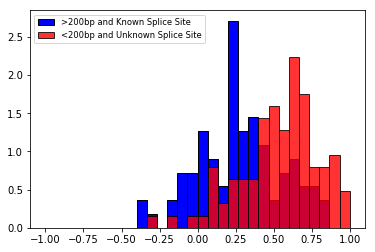

In [96]:
pylab.hist(longKnownSpliceCorrelations, bins=30, range=(-1,1), edgecolor="black", normed=True, color="blue", label=">200bp and Known Splice Site")
pylab.hist(shortUnknownSpliceCorrelations, bins=30, range=(-1,1), edgecolor="black", normed=True, color="red", alpha=0.8,  label="<200bp and Unknown Splice Site")
pylab.legend(fontsize="small")
pylab.savefig("./images/10_filteredSpliceLength", dpi=300)

In [178]:
"""
Plotting based on suppressors vs oncogenes
"""

# File with cancer genes
TPM = 20
oncoFile = "/shared/sudlab1/General/projects/utrons_project/misc_files/cancerUtrons/oncogenes_%dTPM.txt" % TPM
suppFile = "/shared/sudlab1/General/projects/utrons_project/misc_files/cancerUtrons/suppresor_%dTPM.txt" % TPM
unknFile = "/shared/sudlab1/General/projects/utrons_project/misc_files/cancerUtrons/unknown_%dTPM.txt" % TPM

oncoDf = pd.read_csv(oncoFile, sep="\t", header=None)
suppDf = pd.read_csv(suppFile, sep="\t", header=None)
unknDf = pd.read_csv(unknFile, sep="\t", header=None)

oncoTpms = allUtronTpms[allUtronTpms["Name"].isin(oncoDf[0])]
oncoProps = allUtronProportions[allUtronProportions["Name"].isin(oncoDf[0])]

suppTpms = allUtronTpms[allUtronTpms["Name"].isin(suppDf[0])]
suppProps = allUtronProportions[allUtronProportions["Name"].isin(suppDf[0])]

unknTpms = allUtronTpms[allUtronTpms["Name"].isin(unknDf[0])]
unknProps = allUtronProportions[allUtronProportions["Name"].isin(unknDf[0])]


oncoCorrelations = getCorrelations(oncoProps, oncoTpms)
unknCorrelations = getCorrelations(unknProps, unknTpms)
suppCorrelations = getCorrelations(suppProps,suppTpms)

/home/mba13ns/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/mba13ns/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


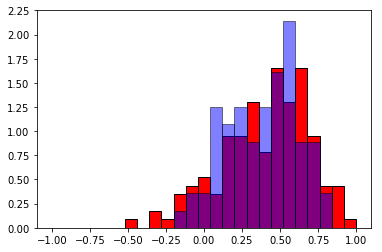

In [179]:
pylab.hist(oncoCorrelations, bins=25, range=(-1,1), edgecolor="black", normed=True, color="red")
pylab.hist(suppCorrelations, bins=25, range=(-1,1), edgecolor="black", normed=True, color="blue", alpha=0.5,)
pylab.legend()